In [151]:
import pandas as pd
import numpy as np
import matplotlib as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn import svm
from sklearn.metrics import r2_score

%matplotlib inline

# Questions:

 - How to achieve the best price on AirBNB?
 - How to achieve good reviews
 - Is it possile to make an accurate predictive model for listing price based on machine leraning

## Data gathering, assessing and cleaning

The next cells will contain datawrangling work


In [152]:
# Data gathering
# Import data into dataframes
calendar = pd.read_csv("./seattle/calendar.csv")
listings = pd.read_csv("./seattle/listings.csv")
reviews = pd.read_csv("./seattle/reviews.csv")

In [153]:
# Assessing
print("Size of dataframes, rows, columns \n", 
      "Calendar : ", calendar.shape, "\n",
      "Listings : ", listings.shape, "\n",
      "Reviews : ", reviews.shape,)

Size of dataframes, rows, columns 
 Calendar :  (1393570, 4) 
 Listings :  (3818, 92) 
 Reviews :  (84849, 6)


In [154]:
listings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3818 entries, 0 to 3817
Data columns (total 92 columns):
id                                  3818 non-null int64
listing_url                         3818 non-null object
scrape_id                           3818 non-null int64
last_scraped                        3818 non-null object
name                                3818 non-null object
summary                             3641 non-null object
space                               3249 non-null object
description                         3818 non-null object
experiences_offered                 3818 non-null object
neighborhood_overview               2786 non-null object
notes                               2212 non-null object
transit                             2884 non-null object
thumbnail_url                       3498 non-null object
medium_url                          3498 non-null object
picture_url                         3818 non-null object
xl_picture_url                      3498

In [155]:
# Cleaning

# Create some extra features based on amenities
listings['TV'] = listings.amenities.str.contains("tv", case=False)
listings['Internet'] = listings.amenities.str.contains('internet|wireless', case=False)
listings['Parking'] = listings.amenities.str.contains('parking', case=False)
listings['Washer'] = listings.amenities.str.contains('washer', case=False)
listings['Dryer'] = listings.amenities.str.contains('dryer', case=False)
listings['AirCon'] = listings.amenities.str.contains('air condition|air conditioning', case=False)


### Addressing missing values

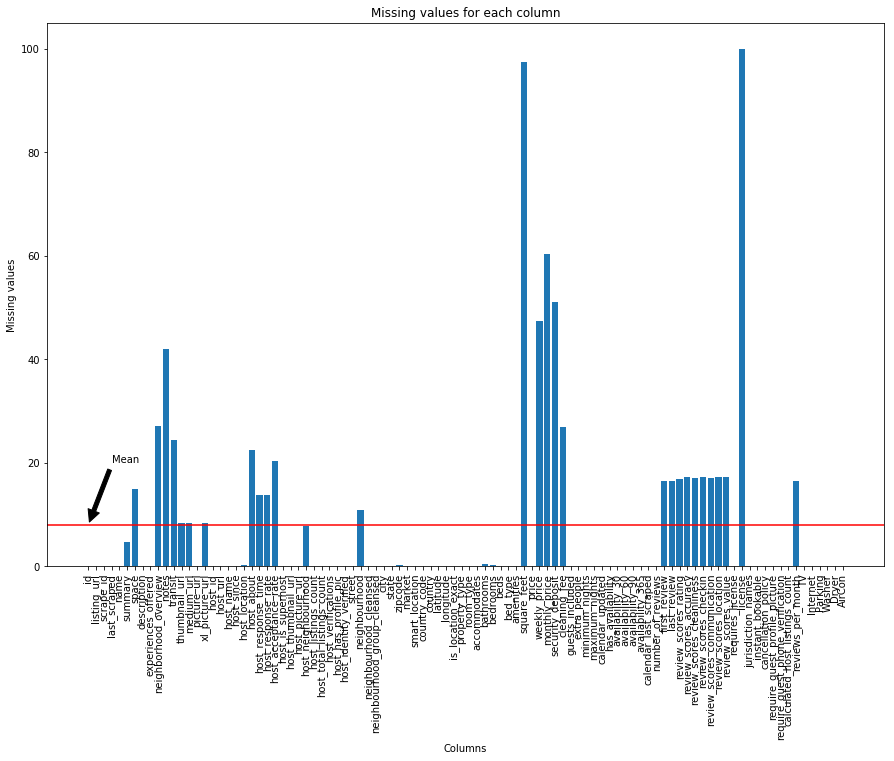

In [156]:
# List comprehensions for headers and corresponding missing values where series has missing values
missing_percent = [(listings[series].isnull().sum()/len(listings[series]))*100 for series in list(listings) ]
headers_missing = [series for series in list(listings)  ]

mean = np.mean(missing_percent)
fig, ax = plt.pyplot.subplots(figsize=(15,10))
plt.pyplot.title("Missing values for each column")
plt.pyplot.xlabel("Columns")
plt.pyplot.ylabel("Missing values")
plt.pyplot.axhline(y=mean, c='r', label='"Mean"')

ax.annotate('Mean', xy=(0, mean), xytext=(3, 20),
            arrowprops=dict(facecolor='black', shrink=0.05),
            )
plt.pyplot.bar(headers_missing, missing_percent)
plt.pyplot.xticks(rotation=90);


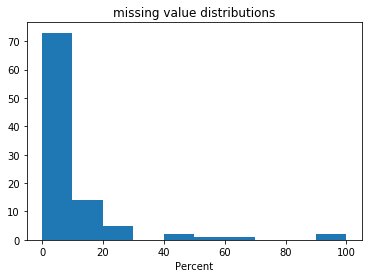

In [157]:
# Get a missingvalue distribution in order to set a cut-off point for missing values
plt.pyplot.title("missing value distributions")
plt.pyplot.xlabel("Percent")
plt.pyplot.hist(missing_percent);


In [158]:
# Remove outlier columns
def remove_outlier_col(df, thresh):
    outlier_columns = []
    outlier_value = []
    for i in list(df):
        if ((df[i].isnull().sum() / len(df[i])) > thresh):
           
            outlier_columns.append(i)
            outlier_value.append(df[i].isnull().sum())
        
    return outlier_columns, outlier_value

In [159]:
outlier_col, outlier_value = remove_outlier_col(listings, 0.2)

In [160]:
for i in zip(outlier_col, outlier_value):
    print(i)

('neighborhood_overview', 1032)
('notes', 1606)
('transit', 934)
('host_about', 859)
('host_acceptance_rate', 773)
('square_feet', 3721)
('weekly_price', 1809)
('monthly_price', 2301)
('security_deposit', 1952)
('cleaning_fee', 1030)
('license', 3818)


In [161]:
listings.drop(outlier_col, axis=1, inplace=True)

In [162]:
# # Distributions
# fig, ax = plt.pyplot.subplots(figsize=(20, 20))
# listings.hist(ax=ax)
# ;

### Categorical features

In [163]:
# I used this cell for analyzing which string columns to keep and which to drop
list(listings.select_dtypes(include=['object']))

['listing_url',
 'last_scraped',
 'name',
 'summary',
 'space',
 'description',
 'experiences_offered',
 'thumbnail_url',
 'medium_url',
 'picture_url',
 'xl_picture_url',
 'host_url',
 'host_name',
 'host_since',
 'host_location',
 'host_response_time',
 'host_response_rate',
 'host_is_superhost',
 'host_thumbnail_url',
 'host_picture_url',
 'host_neighbourhood',
 'host_verifications',
 'host_has_profile_pic',
 'host_identity_verified',
 'street',
 'neighbourhood',
 'neighbourhood_cleansed',
 'neighbourhood_group_cleansed',
 'city',
 'state',
 'zipcode',
 'market',
 'smart_location',
 'country_code',
 'country',
 'is_location_exact',
 'property_type',
 'room_type',
 'bed_type',
 'amenities',
 'price',
 'extra_people',
 'calendar_updated',
 'has_availability',
 'calendar_last_scraped',
 'first_review',
 'last_review',
 'requires_license',
 'jurisdiction_names',
 'instant_bookable',
 'cancellation_policy',
 'require_guest_profile_picture',
 'require_guest_phone_verification']

In [164]:
# I saw that scrape_id contains the same value for all rows and that host_listings_count is the same as host_total_listings_count
listings.drop(['scrape_id', 'host_listings_count'], axis=1, inplace=True)

In [165]:
# Theese are the features i decided to reencode and to make numeric out of the categorical features
one_hot_encode = ['cancellation_policy', 'neighbourhood_group_cleansed', 'property_type', 'bed_type', 'host_identity_verified',
                  'host_response_time', 'host_is_superhost', 'room_type', 'instant_bookable']
    
make_numeric = ['host_response_rate', 'price', 'extra_people' ]    
    

In [166]:
# Convert to numeric values
listings.host_response_rate = listings.host_response_rate.str.replace("%", "")
listings.host_response_rate = pd.to_numeric(listings.host_response_rate)

listings.price = listings.price.str.replace("$", "")
listings.price = listings.price.str.replace(",", "")
listings.price = pd.to_numeric(listings.price)

listings.extra_people = listings.extra_people.str.replace("$", "")
listings.extra_people = pd.to_numeric(listings.extra_people);

In [167]:
list(listings.select_dtypes(include=['object']));

In [168]:
drop_num = ['id', 'host_id', 'latitude', 'longitude', 'review_scores_accuracy', 'review_scores_cleanliness',
            'review_scores_communication', 'review_scores_location', 'review_scores_checkin','review_scores_value', 
            'reviews_per_month', 'calculated_host_listings_count']

drop_object = [i for i in list(listings.select_dtypes(include=['object'])) if i not in make_numeric + one_hot_encode]

In [169]:
listings.drop(drop_num + drop_object, axis=1, inplace=True)

In [170]:
listings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3818 entries, 0 to 3817
Data columns (total 32 columns):
host_response_time              3295 non-null object
host_response_rate              3295 non-null float64
host_is_superhost               3816 non-null object
host_total_listings_count       3816 non-null float64
host_identity_verified          3816 non-null object
neighbourhood_group_cleansed    3818 non-null object
property_type                   3817 non-null object
room_type                       3818 non-null object
accommodates                    3818 non-null int64
bathrooms                       3802 non-null float64
bedrooms                        3812 non-null float64
beds                            3817 non-null float64
bed_type                        3818 non-null object
price                           3818 non-null float64
guests_included                 3818 non-null int64
extra_people                    3818 non-null float64
minimum_nights                  3818 non

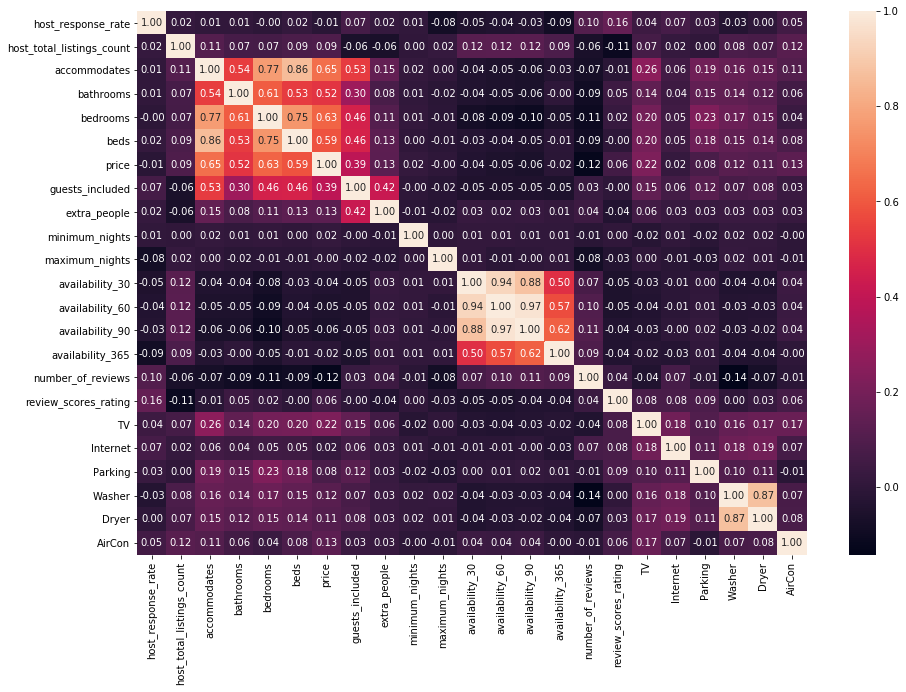

In [171]:
fig, ax = plt.pyplot.subplots(figsize=(15,10))
sns.heatmap(listings.corr(), annot=True, fmt='.2f');

In [172]:
highcorr = ['beds', 'bedrooms', 'availability_60', 'availability_90', 'availability_365']

listings.drop(highcorr, axis=1, inplace=True)

''

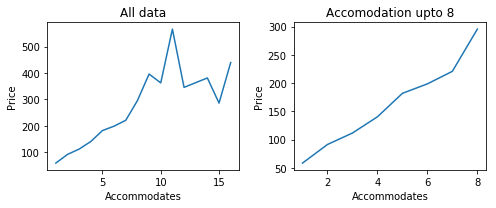

In [173]:
accom = pd.DataFrame(listings.groupby("accommodates")['price'].mean(), columns=['price'])

f,a = plt.pyplot.subplots(figsize=(7,3))
plt.pyplot.subplot(1,2,1)
plt.pyplot.title("All data")
plt.pyplot.ylabel("Price")
plt.pyplot.xlabel("Accommodates")
plt.pyplot.plot(accom)

plt.pyplot.subplot(1,2,2)
plt.pyplot.title("Accomodation upto 8")
plt.pyplot.ylabel("Price")
plt.pyplot.xlabel("Accommodates")
plt.pyplot.plot(accom[:8])

plt.pyplot.tight_layout()
;


In [174]:
# Drop listings that can accommodate more than 8 people as its very noisy 
listings = listings[listings.accommodates <= 8]

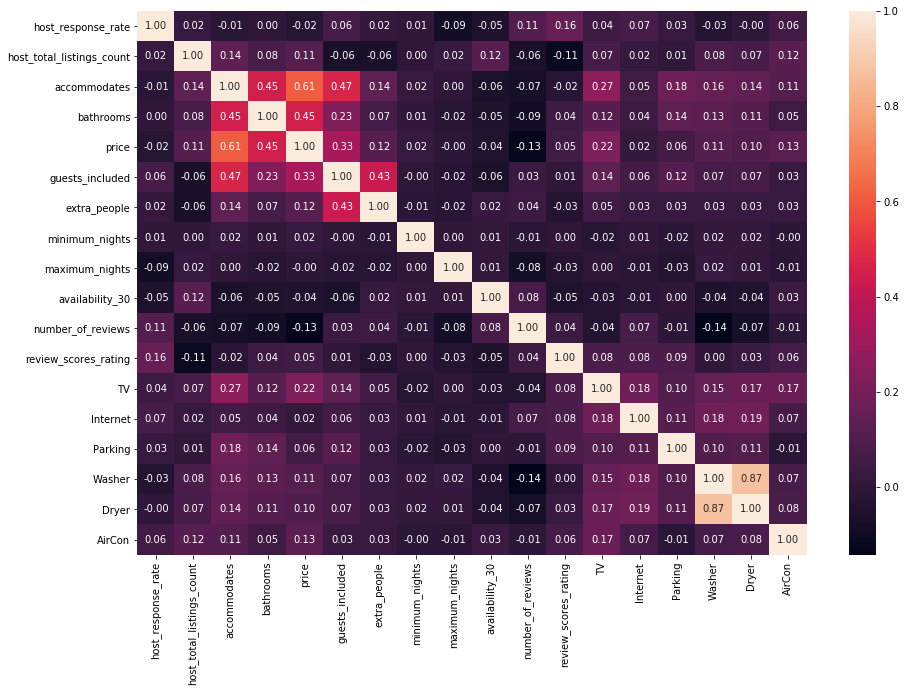

In [175]:
fig, ax = plt.pyplot.subplots(figsize=(15,10))
sns.heatmap(listings.corr(), annot=True, fmt='.2f');

In [176]:
# Mean listings price per neigbourhood

hood = pd.DataFrame(listings.groupby('neighbourhood_group_cleansed')['price'].mean().sort_values(ascending=False))
hood['data_points'] = listings.neighbourhood_group_cleansed.value_counts()
hood

,price,data_points
neighbourhood_group_cleansed,,
Magnolia,166.600000,55
Downtown,152.388258,528
Queen Anne,149.314879,289
Cascade,140.101124,89
West Seattle,138.181818,198
Central Area,123.047222,360
Capitol Hill,122.230631,555
Ballard,118.964444,225
Other neighborhoods,117.512723,786


## Question 1: How to get the best price

We can see from the correlation heatmap aswell as the "accommodates vs price" chart that the main driver for price is how many people the listing can accommodate. The relationship is almost perfectly linear. Other features that are latent features of accommodation (gives more or less the same information) such as number of bedrooms, beds, bathrooms and guests included are also highly correlated. From the cell above we can also see that the average price for listings varies alot for different neighbourhoods. Magnolia, Downtown and Queen Anne are the three most expensive areasm, while Northgate, University District and Delridge are the cheapest ones.

There is a negative correlation to number of reviews which is probably due to some bad reviews for most listings that has been reviewed. 

So the answer to the question is that you should accommodate as many people as possible in order to get the best price on AirBNB. The listings needs to be in the right area and its also important to get good reviews but not as important as to accommodate as many as possible. having a TV and a parking spot is also adviced aswell as washer and air condition

## Question 2: How to achive better reviews?

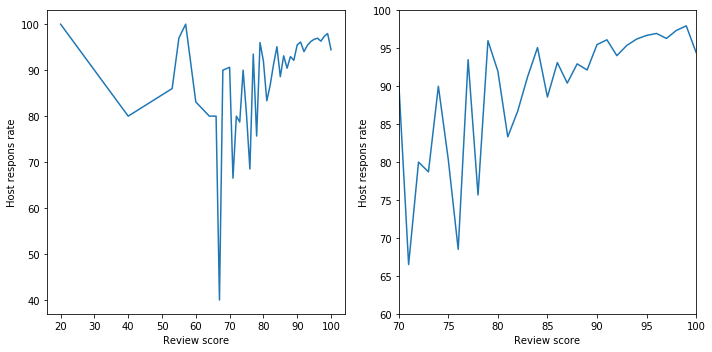

In [177]:
# visulizing the relationship between resonse rate and review score
host = pd.DataFrame(listings.groupby('review_scores_rating')['host_response_rate'].mean())
plt.pyplot.subplots(figsize=(10,5))
plt.pyplot.title("Response rate vs review score")
plt.pyplot.subplot(1,2,1)
plt.pyplot.plot(host)
plt.pyplot.ylabel("Host respons rate")
plt.pyplot.xlabel("Review score")

# data under 70 for review score seems noisy so i made a subplot for datapoints above
plt.pyplot.subplot(1,2,2)
plt.pyplot.plot(host)
plt.pyplot.ylabel("Host respons rate")
plt.pyplot.xlabel("Review score")
plt.pyplot.xlim(70,100)
plt.pyplot.ylim(60,100)

plt.pyplot.tight_layout()


From the correlation heatmap we can see that the most important factor for getting good reviews is to respond on all requests that guests have(host response rate), which isnt too surprising. 

It also seems that hosts with many listings gets worse reviews than those who have 1 or few. One could think that having many listings could imply a worse response rate due the increased amount of inquires, but there is a very small correlation between response rate and listings count. I dont have data too support this theory, but I belive that listings by hosts with many other listings are perceived as simple and sterile with focus on maximizing economic profits while listings from people who live in the same appartment are perceived as more cozy and warm.

There is a small correlation between bathrooms, price and review score. I belive this is due to standard. Higher standard listings get better reviews. limitations on nights are bad for review score and availablity is relevant.

So to get the best reviews, you should:
 - Not have too many listings
 - Respond on every inquery you get
 - Dont have limitations on nights to stay
 - include ammenities like parking space, TV and Internet
 - High availibility (this one you might disregard if you want to make money :) )

# Predicting listing price with machine learning

In [178]:
# One hot encode categorical features before machine learning
listings_ohe = pd.get_dummies(listings, drop_first=True);

In [179]:
# Split dataset into subsets for different handling of missing values
full_df = listings_ohe.dropna().copy()
mean_imputed_df = listings_ohe.fillna(listings.mean()).copy()


In [180]:
# Length of each dataset
print("Length full_df : ", len(scaled_full),
      "Length of imputed_df : ", len(scaled_imp))

Length full_df :  2095 Length of imputed_df :  2814


In [181]:
# Split into targets and features
target = full_df.price.copy()
features = full_df.drop('price', axis=1).copy()

target_imp = mean_imputed_df.price.copy()
features_imp = mean_imputed_df.drop('price', axis=1).copy()

In [182]:
# Split to training set and testing set
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.25)

X_train_imp, X_test_imp, y_train_imp, y_test_imp = train_test_split(features_imp, target_imp, test_size=0.25)

## ADAboost

In [354]:
param_dist = {
 'n_estimators': [500, 2000],
 'learning_rate' : [0.01,0.05,0.1,0.3,1],
 'loss' : ['linear', 'square', 'exponential']
 }



adamodel = RandomizedSearchCV(AdaBoostRegressor(), param_distributions = param_dist, cv=3, n_iter = 20, n_jobs=-1);
                              
adamodel.fit(X_train, y_train)


RandomizedSearchCV(cv=3, error_score='raise',
          estimator=AdaBoostRegressor(base_estimator=None, learning_rate=1.0, loss='linear',
         n_estimators=50, random_state=None),
          fit_params=None, iid=True, n_iter=20, n_jobs=-1,
          param_distributions={'n_estimators': [500, 2000], 'learning_rate': [0.01, 0.05, 0.1, 0.3, 1], 'loss': ['linear', 'square', 'exponential']},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring=None, verbose=0)

In [355]:
y_pred = adamodel.predict(X_test_imp)

In [356]:
r2_score(y_test, y_pred)

0.40381211102599324

#### R2 scores for AdaBoost
- full_df: 0.44
- imputed_df : 0.40    

## SVM

In [82]:
scaler = preprocessing.StandardScaler()

scaled_x = scaler.fit_transform(X_train)
test_x = scaler.transform(X_test)
scaled_x_imp = scaler.fit_transform(X_train_imp)
test_x_imp = scaler.transform(X_test_imp)

In [86]:
param_dist_svm = {
 'kernel': ['linear', 'rbf', 'poly'],
 'C' : [0.001,0.05,0.1]

 }

svmmodel = GridSearchCV(svm.SVC(), param_grid=param_dist_svm )
svmmodel.fit(scaled_x_imp, y_train_imp)

C:\anaconda\lib\site-packages\sklearn\model_selection\_split.py:605: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)


GridSearchCV(cv=None, error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'kernel': ['linear', 'rbf', 'poly'], 'C': [0.001, 0.05, 0.1]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [87]:
svmpred = svmmodel.predict(test_x_imp)
r2_score(y_test_imp, svmpred)

0.39011210839752497

#### R2 scores for SVM
- full_df: 0.50
- imputed_df : 0.39


# Randomforest

In [183]:
from scipy.stats import randint
# specify parameters and distributions to sample from
param_dist = {"max_depth": randint(3,15),
              "n_estimators" : [100, 1000],
              "min_samples_split": randint(2, 11),
              "bootstrap": [True, False],
              "min_samples_leaf" : randint(1,10)
                            }
n_iter_search = 20
randommodel = RandomizedSearchCV(RandomForestRegressor(), param_distributions=param_dist,
                                   n_iter=n_iter_search, cv=5)
randommodel.fit(X_train, y_train);

In [184]:
pred = randommodel.predict(X_test)

In [185]:
r2_score(y_test, pred)

0.6000112351466138

#### R2 scores for RandomForest
- full_df: 0.60
- imputed_df : 0.56  


### Best model is Random Forest